In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import scipy
from matplotlib import rc
from scipy.signal import savgol_filter


rc('text', usetex=True)
rc('text.latex', preamble=r'\usepackage{cmbright}')
rc('font', **{'family': 'sans-serif', 'sans-serif': ['Helvetica']})

%matplotlib inline

# This enables SVG graphics inline. 
%config InlineBackend.figure_formats = {'png', 'retina'}

rc = {'lines.linewidth': 2, 
      'axes.labelsize': 18, 
      'axes.titlesize': 18, 
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style("dark")

mpl.rcParams['xtick.labelsize'] = 16 
mpl.rcParams['ytick.labelsize'] = 16 
mpl.rcParams['legend.fontsize'] = 14

import sys
sys.path.append('./utils')
import covid_utils as cv

In [18]:
from covidmx import CovidMX

# df = CovidMX(source='Serendipia').get_data()
df.sort_values('fecha_sintomas', inplace=True)
df.head()
df['fecha_sintomas'] = pd.to_datetime(df.fecha_sintomas)

In [19]:
cumdf = df.groupby(['nom_ent', 'fecha_sintomas'])['id_registro'].count().reset_index()
cumdf['cases'] = cumdf.groupby('nom_ent').id_registro.apply(np.cumsum)

No handles with labels found to put in legend.
No handles with labels found to put in legend.
/opt/anaconda3/envs/covid/lib/python3.8/site-packages/scipy/optimize/minpack.py:807: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


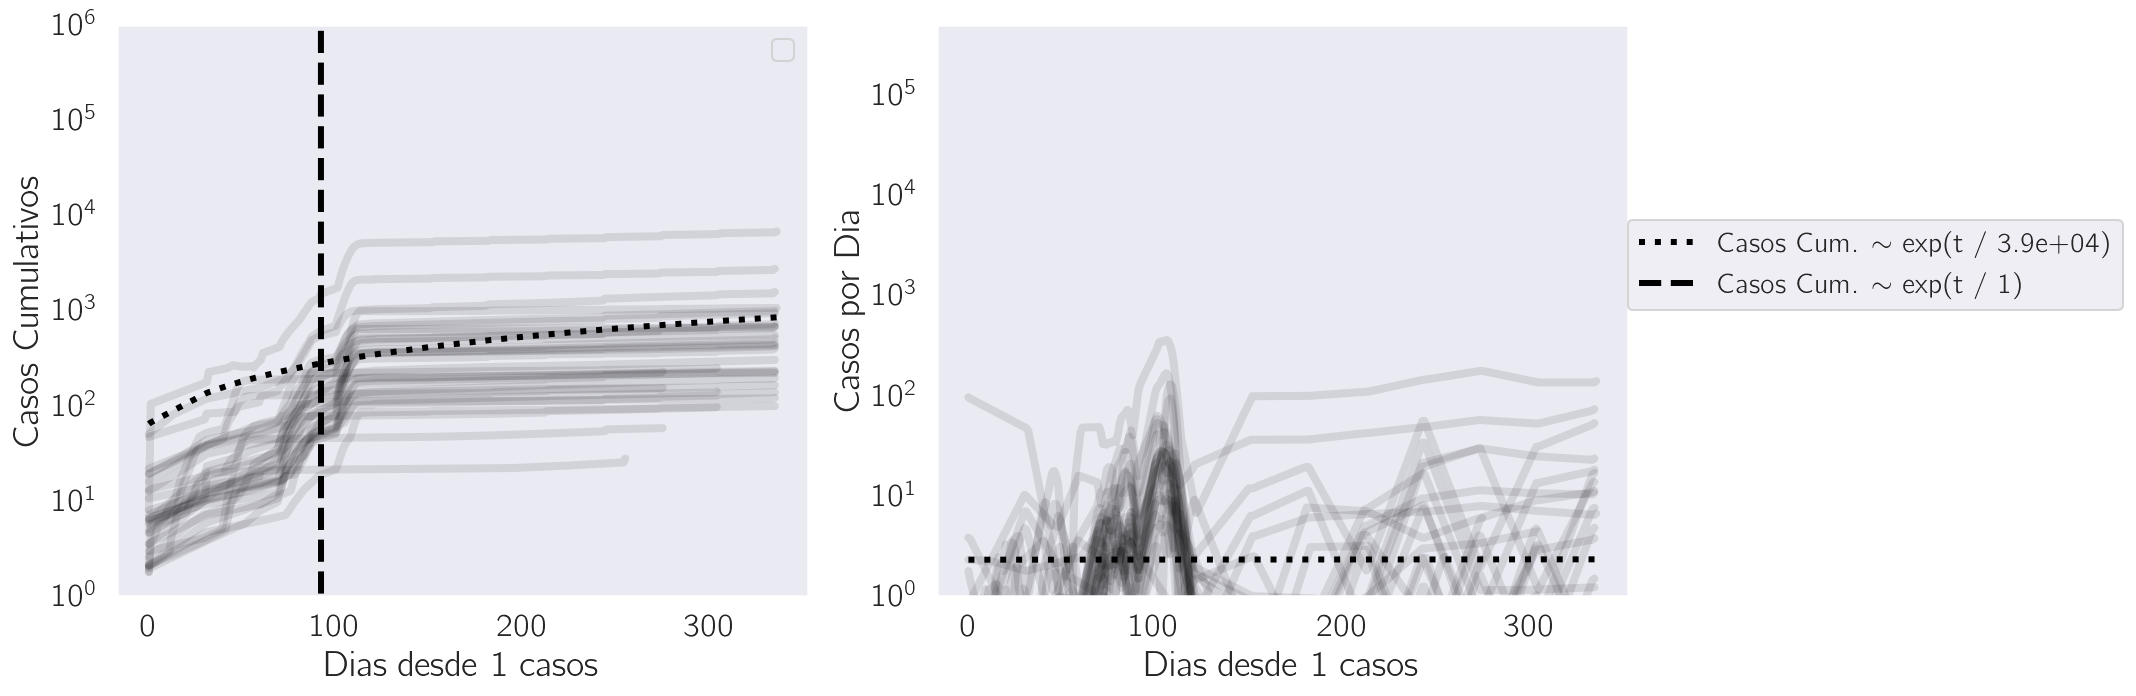

In [22]:
def growth(t, a, tau, b):
    """Exponential growth function."""
    return a * np.exp(t / tau) + b

def plot_mx(cumdf, ax, gradient=False, col='cases', cond = (cumdf.cases > 1)):
    for n, g in cumdf[cond].groupby('nom_ent'):
        x = (g.fecha_sintomas- g.fecha_sintomas.min()) / dt.timedelta(days=1)

        if n == 'CIUDAD DE MÉXICO':
            color = 'green'
            alpha = 1
            label='Cd. México'
            s = 7
            zorder = np.inf
        else:
            color = 'black'
            alpha = 0.1
            label = '_'
            s = 4
            zorder = 0

        y = savgol_filter(g[col], 7, 3)
        if gradient:
            y = np.gradient(y, x)
        ax.plot(x, y, color=color, alpha=alpha, label=label, lw=s, zorder=zorder)

    ax.set_yscale('log')
    ax.set_xlabel('Dias desde 1 casos')
    ax.legend()
    return ax

def fit_to_subset(g, cond, **kwargs):
    x = (g.fecha_sintomas - g[cond].fecha_sintomas.min()) / dt.timedelta(days=1)
    xr = (g.fecha_sintomas - g.fecha_sintomas.min()) / dt.timedelta(days=1)
    
    xp = (g[cond].fecha_sintomas - g[cond].fecha_sintomas.min()) / dt.timedelta(days=1)
    fit, covs = scipy.optimize.curve_fit(growth, xp, g[cond].cases)
    
    a, tau, b = fit
    ax[0].plot(xr, growth(x, a, tau, b), label='Casos Cum. $\sim$ exp(t / {0:.2g})'.format(tau), zorder=np.inf, **kwargs)
    ax[1].plot(xr, a / tau * np.exp(x / tau), label='Casos Cum. $\sim$ exp(t / {0:.2g})'.format(tau), zorder=np.inf, **kwargs)
    return fit, covs


fig, ax = plt.subplots(ncols=2, figsize=(15, 5))

ax[0] = plot_mx(cumdf, ax[0])
ax[1] = plot_mx(cumdf, ax[1], 'id_registro')

for n, g in cumdf[cumdf.cases > 1].groupby('nom_ent'):
    if n != 'Ciudad de México':
        continue
    fit1, covs1 = fit_to_subset(g, (g.cases > 1) & (g.cases <150), ls='dotted', lw=3, color='black')
    fit2, covs2 = fit_to_subset(g, (g.cases > 100) & (g.cases < 4000), ls='--', lw=3, color='black')
    break

ax[0].set_ylabel('Casos Cumulativos')
ax[1].set_ylabel('Casos por Dia')
plt.legend(loc=(1, .5))
ax[0].set_ylim(1, 10 ** 6)
ax[1].set_ylim(1, 5 * 10 ** 5)
plt.tight_layout()

In [ ]:
# fetch NYT data:
url = 'https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-states.csv'
nyt = pd.read_csv(url, usecols=[0, 1, 3, 4], parse_dates=['date'], squeeze=True)
nyt = nyt[nyt.date < dt.datetime(year=2020, month=4, day=5)]

In [ ]:
tau_cases, cov_cases = cv.plot_time(nyt, 'cases', alpha=0.4)

In [ ]:
fig, ax = plt.subplots()

first = True
for name, t in tau_cases.items():
    if (cov_cases[name] <= 0) | (cov_cases[name] > 10 ** 5):
        continue
    if first:
        label = 'Estado de EUA'
    else:
        label = '_Estado de EUA'
    plt.scatter(t, np.sqrt(cov_cases[name]), color='black', alpha=0.5, label=label)
    first = False
plt.scatter(fit1[1], np.sqrt(np.diag(covs1)[1]), s=100, label='Primera Fase')
plt.scatter(fit2[1], np.sqrt(np.diag(covs2)[1]), s=100, label='Segunda Fase')

plt.ylim(10 ** -1, 100)
plt.xlim(1, 40)
plt.yscale('log')
plt.legend()
plt.xlabel(r'$\tau$')
plt.ylabel(r'$\sigma_{\tau}$')

_ = fig.suptitle('Los datos mexicanos tienen anomalías', fontsize=20)

In [21]:
df.nom_ent.unique()

array(['Puebla', 'Ciudad de México', 'Quintana Roo', 'Jalisco', 'Sinaloa',
       'Baja California', 'Baja California Sur',
       'Veracruz de Ignacio de la Llave', 'Morelos', 'Sonora', 'México',
       'Querétaro', 'Yucatán', 'Michoacán de Ocampo', 'Tlaxcala',
       'Tabasco', 'Tamaulipas', 'Coahuila de Zaragoza', 'Guerrero',
       'Hidalgo', 'Aguascalientes', 'Chihuahua', 'Nuevo León',
       'Guanajuato', 'San Luis Potosí', 'Nayarit', 'Chiapas', 'Campeche',
       'Zacatecas', 'Durango', 'Oaxaca', 'Colima'], dtype=object)